In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=54072c840b00a54c3b63e4b651cebc8a6a0bb2bbd81d9b40e282146d172deb88
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
import pyspark as sp

sc = sp.SparkContext.getOrCreate()
print(sc)
print(sc.version)

<SparkContext master=local[*] appName=pyspark-shell>
3.4.1


In [3]:
from pyspark.sql import SparkSession

#Creating spark
spark=SparkSession.builder.getOrCreate()

#Printing spark

print(spark)

In [4]:
import pandas as pd
import numpy as np
import pyspark.sql.functions as F

import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.style.use('ggplot')
sns.set_style("whitegrid")

from scipy import stats

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, VectorIndexer, StringIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor


In [5]:
data = spark.read.csv("train_dataset.csv", header= True)
data.show()

+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+
|           jobId|companyId|       jobType|     degree|     major| industry|yearsExperience|milesFromMetropolis|
+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|      MATH|   HEALTH|             10|                 83|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|      NONE|      WEB|              3|                 73|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|   PHYSICS|   HEALTH|             10|                 38|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL| CHEMISTRY|     AUTO|              8|                 17|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|   PHYSICS|  FINANCE|              8|                 16|
|JOB1362684407692|   COMP15|       MANAGER|   DOCTORAL|   COMPSCI|  FINANCE|              2|    

In [6]:
data.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: string (nullable = true)
 |-- milesFromMetropolis: string (nullable = true)



**The columns such as yearsExperience and milesFromMetropolis is considered as string. Thus converting these two columns into interger tye.**

In [7]:
data = data.withColumn("yearsExperience",data.yearsExperience.cast('int'))

data =  data.withColumn("milesFromMetropolis", data.milesFromMetropolis.cast('int'))

data.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: integer (nullable = true)
 |-- milesFromMetropolis: integer (nullable = true)



**As the values are of integer type in the data, the datatype of the column couls also be inferred from its schema using inferschema.**

In [8]:
data1 = spark.read.csv("train_dataset.csv", header= True, inferSchema= True)

In [9]:
data1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: integer (nullable = true)
 |-- milesFromMetropolis: integer (nullable = true)



In [10]:
data2 = spark.read.csv("train_salaries.csv", header = True, inferSchema = True)

In [11]:
data2.show()

+----------------+------+
|           jobId|salary|
+----------------+------+
|JOB1362684407687|   130|
|JOB1362684407688|   101|
|JOB1362684407689|   137|
|JOB1362684407690|   142|
|JOB1362684407691|   163|
|JOB1362684407692|   113|
|JOB1362684407693|   178|
|JOB1362684407694|    73|
|JOB1362684407695|    31|
|JOB1362684407696|   104|
|JOB1362684407697|   102|
|JOB1362684407698|   144|
|JOB1362684407699|    79|
|JOB1362684407700|   193|
|JOB1362684407701|    47|
|JOB1362684407702|   172|
|JOB1362684407703|    47|
|JOB1362684407704|   126|
|JOB1362684407705|   122|
|JOB1362684407706|    95|
+----------------+------+
only showing top 20 rows



In [12]:
data2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: integer (nullable = true)



**Combining two dataframes**

The above two datafranes are combined using jobID. After combining two dataframes in order to avoid ambiguity, renaming of jobId column in the second dataframe is done and that is dropped

In [13]:
data2 = data2.withColumnRenamed('jobId','job_id')

In [14]:
salary_data = data1.join(data2, data1.jobId == data2.job_id)

In [15]:
salary_data= salary_data.drop('job_id')

salary_data.show(5)

+----------------+---------+-------+-----------+---------+---------+---------------+-------------------+------+
|           jobId|companyId|jobType|     degree|    major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+-------+-----------+---------+---------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|    CFO|    MASTERS|     MATH|   HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|    CEO|HIGH_SCHOOL|     NONE|      WEB|              3|                 73|   101|
|JOB1362684407690|   COMP38|MANAGER|   DOCTORAL|CHEMISTRY|     AUTO|              8|                 17|   142|
|JOB1362684407693|   COMP15|    CFO|       NONE|     NONE|   HEALTH|             23|                 24|   178|
|JOB1362684407694|   COMP24| JUNIOR|  BACHELORS|CHEMISTRY|EDUCATION|              9|                 70|    73|
+----------------+---------+-------+-----------+---------+---------+---------------+-------------------+

**Checking for duplicate data**

In [16]:
df_duplicates = salary_data.groupBy(salary_data.columns).count().filter("count > 1")

df_duplicates.show()

+-----+---------+-------+------+-----+--------+---------------+-------------------+------+-----+
|jobId|companyId|jobType|degree|major|industry|yearsExperience|milesFromMetropolis|salary|count|
+-----+---------+-------+------+-----+--------+---------------+-------------------+------+-----+
+-----+---------+-------+------+-----+--------+---------------+-------------------+------+-----+



This indicates that are no dulpicate rows.


**Checking Missing Values**

In [17]:
salary_data.show()

+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+------+
|           jobId|companyId|       jobType|     degree|     major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|      MATH|   HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|      NONE|      WEB|              3|                 73|   101|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL| CHEMISTRY|     AUTO|              8|                 17|   142|
|JOB1362684407693|   COMP15|           CFO|       NONE|      NONE|   HEALTH|             23|                 24|   178|
|JOB1362684407694|   COMP24|        JUNIOR|  BACHELORS| CHEMISTRY|EDUCATION|              9|                 70|    73|
|JOB1362684407695|   COMP20|       JANIT

In [18]:
Dict_Null = {col:salary_data.filter(salary_data[col].isNull()).count() for col in salary_data.columns}
Dict_Null

{'jobId': 0,
 'companyId': 0,
 'jobType': 0,
 'degree': 0,
 'major': 0,
 'industry': 0,
 'yearsExperience': 0,
 'milesFromMetropolis': 0,
 'salary': 0}

Though the count for null values is zero still certian columns have value as none so checking the number of none values in the dataframe.

In [19]:
print("Number Of missing values for jobtype is ", salary_data.filter(salary_data.jobType == "NONE").count())
print("Number Of missing values for degree is ", salary_data.filter(salary_data.degree == "NONE").count())
print("Number Of missing values for major is ", salary_data.filter(salary_data.major == "NONE").count())
print("Number Of missing values for industry is ", salary_data.filter(salary_data.industry == "NONE").count())

Number Of missing values for jobtype is  0
Number Of missing values for degree is  236854
Number Of missing values for major is  532355
Number Of missing values for industry is  0


As there are various jobtypes the columns such as degree and major are not considered as null values and hence they are not dropped.

In [20]:
salary_data.describe(['yearsExperience','milesFromMetropolis','salary']).show()

+-------+-----------------+-------------------+-----------------+
|summary|  yearsExperience|milesFromMetropolis|           salary|
+-------+-----------------+-------------------+-----------------+
|  count|          1000000|            1000000|          1000000|
|   mean|        11.992386|           49.52926|       116.061818|
| stddev|7.212390868885708| 28.877732628720178|38.71793638113286|
|    min|                0|                  0|                0|
|    max|               24|                 99|              301|
+-------+-----------------+-------------------+-----------------+



As the minimum values in the salary column is O, it has to be checked if volunterring typeof jobs is available.

**THE HIGHEST PAID JOB**

In [21]:
salary_data.createOrReplaceTempView("sal_data")

In [22]:
spark.sql('''
      SELECT salary, jobType, industry from sal_data where salary = (select max(salary) from sal_data)
          ''').show()

+------+-------+--------+
|salary|jobType|industry|
+------+-------+--------+
|   301|    CFO|     OIL|
|   301|    CTO|     OIL|
+------+-------+--------+



The highest paid jobs are CFO (Chief financial officer) and CTO (Chief technology officer ) in the OIL industry, with a salary of 301k$.

**TOP 20 jobs in terms of highest salary**

In [23]:
spark.sql('''
      SELECT salary, jobType, industry, RANK () OVER (partition by industry order by salary desc) as Ranking from sal_data
      order by salary DESC LIMIT 20
          ''').show()

+------+-------+--------+-------+
|salary|jobType|industry|Ranking|
+------+-------+--------+-------+
|   301|    CFO|     OIL|      1|
|   301|    CTO|     OIL|      1|
|   298|    CEO|     OIL|      3|
|   294|    CEO| FINANCE|      1|
|   294|    CEO|     OIL|      4|
|   293|    CEO| FINANCE|      2|
|   293|    CEO|     OIL|      5|
|   292|    CEO| FINANCE|      3|
|   292|    CTO| FINANCE|      3|
|   290|    CEO|     WEB|      1|
|   289|    CEO| FINANCE|      5|
|   289|    CFO|     OIL|      6|
|   289|    CTO|     WEB|      2|
|   288|    CFO| FINANCE|      6|
|   288|    CFO| FINANCE|      6|
|   287|    CEO|     OIL|      7|
|   287|    CEO| FINANCE|      8|
|   286|    CEO|     OIL|      8|
|   286|    CTO| FINANCE|      9|
|   286|    CEO| FINANCE|      9|
+------+-------+--------+-------+



**LEAST PAID JOB**

In [24]:
spark.sql('''
      SELECT salary, jobType, industry, RANK () OVER (partition by industry order by salary) as Ranking from sal_data
      order by salary ASC
          ''').show()

+------+--------------+---------+-------+
|salary|       jobType| industry|Ranking|
+------+--------------+---------+-------+
|     0|        JUNIOR|     AUTO|      1|
|     0|       MANAGER|  FINANCE|      1|
|     0|        JUNIOR|      OIL|      1|
|     0|           CTO|     AUTO|      1|
|     0|VICE_PRESIDENT|      WEB|      1|
|    17|       JANITOR|EDUCATION|      1|
|    18|       JANITOR|EDUCATION|      2|
|    18|       JANITOR|EDUCATION|      2|
|    18|       JANITOR|EDUCATION|      2|
|    19|       JANITOR|EDUCATION|      5|
|    19|       JANITOR|EDUCATION|      5|
|    19|       JANITOR|EDUCATION|      5|
|    19|       JANITOR|EDUCATION|      5|
|    19|       JANITOR|EDUCATION|      5|
|    19|       JANITOR|EDUCATION|      5|
|    19|       JANITOR|EDUCATION|      5|
|    19|       JANITOR|EDUCATION|      5|
|    19|       JANITOR|EDUCATION|      5|
|    19|       JANITOR|EDUCATION|      5|
|    20|       JANITOR|EDUCATION|     15|
+------+--------------+---------+-

We can clearly see that the jobs with 0 salary are probably missing values, since they are related for example to OIL and WEB industries, which are very weel paid (as seen before). Moreover, there is also a 'vice president' job, which is impossible to have 0$ salary. We will drop these rows

In [25]:
# Retaining the column that has non zero values
salary_data = salary_data.where(salary_data.salary != 0)

reloading the table with the updated values

In [26]:
salary_data.createOrReplaceTempView("sal_data")

In [27]:
df_q2= spark.sql('''
      SELECT salary, jobType, industry, RANK () OVER (partition by industry order by salary) as Ranking from sal_data
      order by salary ASC
          ''')
df_q2.show()

+------+-------+---------+-------+
|salary|jobType| industry|Ranking|
+------+-------+---------+-------+
|    17|JANITOR|EDUCATION|      1|
|    18|JANITOR|EDUCATION|      2|
|    18|JANITOR|EDUCATION|      2|
|    18|JANITOR|EDUCATION|      2|
|    19|JANITOR|EDUCATION|      5|
|    19|JANITOR|EDUCATION|      5|
|    19|JANITOR|EDUCATION|      5|
|    19|JANITOR|EDUCATION|      5|
|    19|JANITOR|EDUCATION|      5|
|    19|JANITOR|EDUCATION|      5|
|    19|JANITOR|EDUCATION|      5|
|    19|JANITOR|EDUCATION|      5|
|    19|JANITOR|EDUCATION|      5|
|    19|JANITOR|EDUCATION|      5|
|    20|JANITOR|EDUCATION|     15|
|    20|JANITOR|EDUCATION|     15|
|    20|JANITOR|EDUCATION|     15|
|    20|JANITOR|EDUCATION|     15|
|    20|JANITOR|EDUCATION|     15|
|    20|JANITOR|EDUCATION|     15|
+------+-------+---------+-------+
only showing top 20 rows



the lowest paid job is 'janitor', with a minimum salary of 17k$.

**TOP 3 industries in terms of highest salary**

In [28]:
df_q3= spark.sql('''
      SELECT  industry, AVG(salary) as Average_salary from sal_data group by industry order by 2 DESC
          ''')
df_q3.show()

+---------+------------------+
| industry|    Average_salary|
+---------+------------------+
|      OIL|130.95386285634237|
|  FINANCE|  130.747658645164|
|      WEB| 121.6453615446388|
|   HEALTH| 115.7355399110364|
|     AUTO|109.43522152496485|
|  SERVICE|104.44682029458984|
|EDUCATION| 99.44838571898697|
+---------+------------------+



**Displaying the average salary of all the industries**

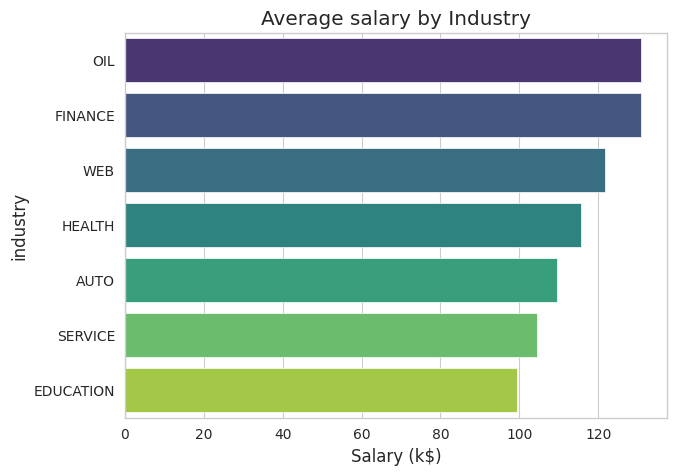

In [29]:
# Conveting to pandas dataframe

pandas_data = df_q3.toPandas()
plt.figure(figsize=(7,5))
sns.barplot(y='industry', x = 'Average_salary', data=pandas_data, palette='viridis')
plt.title('Average salary by Industry')
plt.xlabel('Salary (k$)')
plt.show()

Do workers with more years of experience get paid more?

In [30]:
df_q4 = spark.sql('''

    SELECT salary, jobtype, industry, yearsExperience
    FROM sal_data
    ORDER BY salary DESC
    ''')
df_q4.show()

+------+-------+--------+---------------+
|salary|jobtype|industry|yearsExperience|
+------+-------+--------+---------------+
|   301|    CTO|     OIL|             24|
|   301|    CFO|     OIL|             23|
|   298|    CEO|     OIL|             22|
|   294|    CEO| FINANCE|             24|
|   294|    CEO|     OIL|             19|
|   293|    CEO| FINANCE|             16|
|   293|    CEO|     OIL|             24|
|   292|    CEO| FINANCE|             22|
|   292|    CTO| FINANCE|             24|
|   290|    CEO|     WEB|             20|
|   289|    CTO|     WEB|             24|
|   289|    CFO|     OIL|             23|
|   289|    CEO| FINANCE|             23|
|   288|    CFO| FINANCE|             24|
|   288|    CFO| FINANCE|             21|
|   287|    CEO|     OIL|             22|
|   287|    CEO| FINANCE|             19|
|   286|    CTO| FINANCE|             24|
|   286|    CEO| FINANCE|             24|
|   286|    CEO|     OIL|             16|
+------+-------+--------+---------

In [31]:
df_q4.groupby('jobtype').count().show()

+--------------+------+
|       jobtype| count|
+--------------+------+
|           CTO|125045|
|        JUNIOR|124592|
|       JANITOR|124971|
|           CFO|124369|
|           CEO|124778|
|       MANAGER|125120|
|VICE_PRESIDENT|125234|
|        SENIOR|125886|
+--------------+------+



In [32]:
#Converting to pandas dataframe
df_pandas= df_q4.toPandas()

In [33]:
#Creating a job list

job_list= ['CTO','JUNIOR','JANITOR','CFO','CEO','MANAGER','VICE_PRESIDENT','SENIOR']


Creating the plots with a for loop, including a linear regression to improve the readability of the plots.

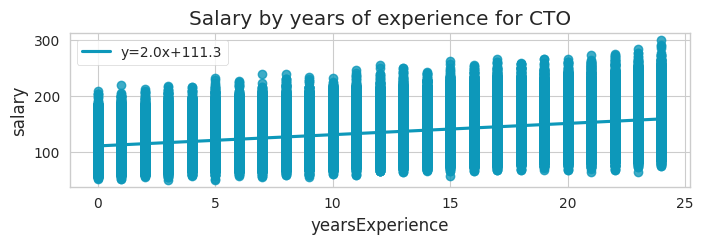

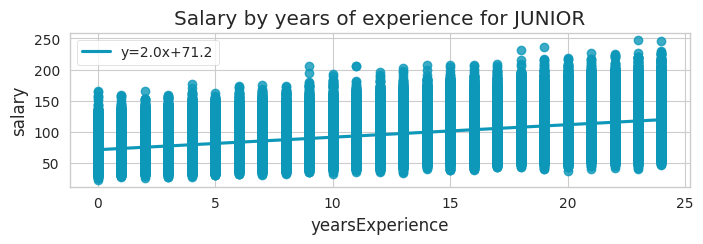

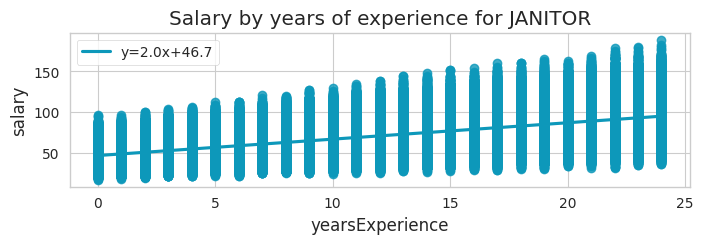

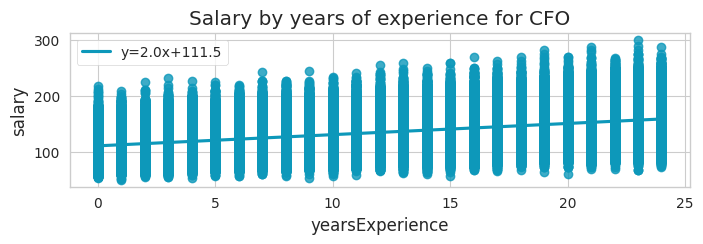

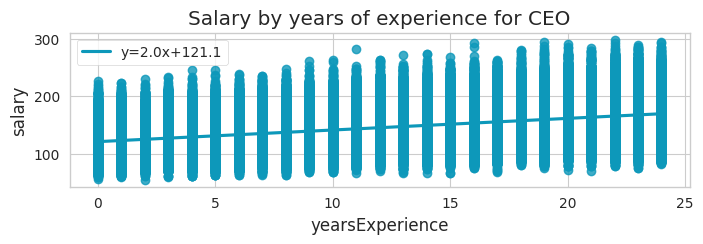

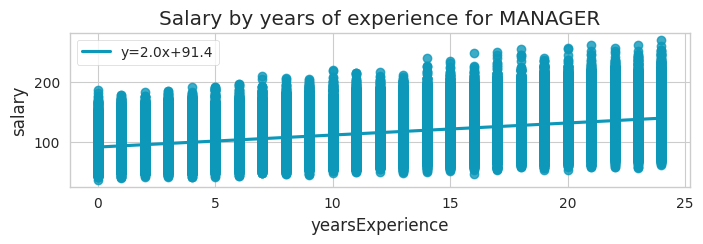

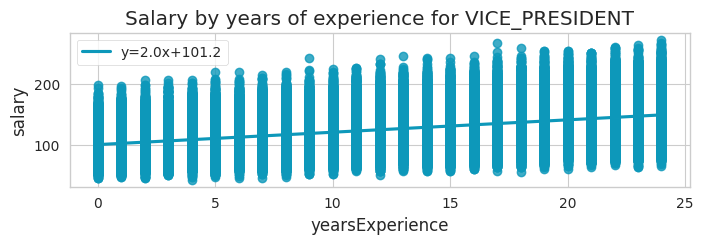

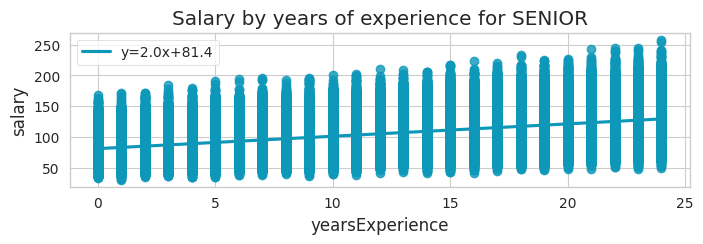

In [34]:
slope_list = []  #to save the slopes of the regression lines
intercept_list = [] #to save the intercepts of the regression lines

for job in job_list:
    df_x = df_pandas.loc[df_pandas['jobtype']==job]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_x['yearsExperience'],df_x['salary'])
    slope_list.append(slope)
    intercept_list.append(intercept)
    plt.figure(figsize=(8,2))
    sns.regplot(x='yearsExperience', y = 'salary', data=df_x, color='#0d98ba', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.legend()
    plt.title('Salary by years of experience for ' + job)
    plt.show()

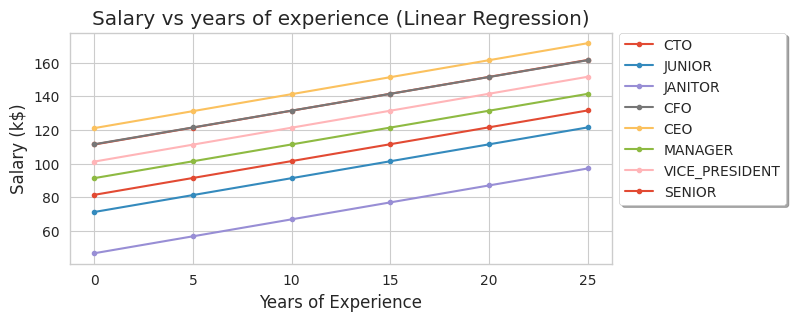

In [35]:
X = np.array([0, 5, 10, 15, 20, 25])
plt.figure(figsize=(7,3))
for i in range(8):
    plt.plot(X, slope_list[i]*X+intercept_list[i],label=job_list[i], marker='.')
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fancybox=True, shadow=True)
plt.ylabel('Salary (k$)')
plt.xlabel('Years of Experience')
plt.title('Salary vs years of experience (Linear Regression)')
plt.show()

An increasing trend between years of experience and salary among all different jobs is observed: this means that more years of experience lead to higher salaries for all the job positions. By looking at the slope and intercept for each linear model, we can see that the slope is rounded to 2.0 for all the positions: this means that, on average, all these jobs see an increase of salary by 2000 dollars annually. The difference is the intercept, which can be interpreted as the average salary of a worker with 0 years of experience. In particular we can see an intercept value of 121.5k\dollar for CEO and 46.7k dollar for janitor.

**Do workers with higher degrees have better paid jobs?***

In [39]:
df_q5 = spark.sql('''
                  SELECT salary, degree, jobtype from sal_data order by salary DESC
                  ''')
df_q5.show()



+------+---------+-------+
|salary|   degree|jobtype|
+------+---------+-------+
|   301| DOCTORAL|    CFO|
|   301|  MASTERS|    CTO|
|   298|  MASTERS|    CEO|
|   294|BACHELORS|    CEO|
|   294| DOCTORAL|    CEO|
|   293| DOCTORAL|    CEO|
|   293| DOCTORAL|    CEO|
|   292|BACHELORS|    CEO|
|   292|  MASTERS|    CTO|
|   290| DOCTORAL|    CEO|
|   289|  MASTERS|    CTO|
|   289|  MASTERS|    CFO|
|   289| DOCTORAL|    CEO|
|   288| DOCTORAL|    CFO|
|   288| DOCTORAL|    CFO|
|   287|  MASTERS|    CEO|
|   287| DOCTORAL|    CEO|
|   286| DOCTORAL|    CEO|
|   286|  MASTERS|    CTO|
|   286| DOCTORAL|    CEO|
+------+---------+-------+
only showing top 20 rows



AS few records have none values in he degree column drooping the values that has none

In [40]:
df_q5= df_q5.replace('NONE',None)
df_q5.show(10)

+------+---------+-------+
|salary|   degree|jobtype|
+------+---------+-------+
|   301|  MASTERS|    CTO|
|   301| DOCTORAL|    CFO|
|   298|  MASTERS|    CEO|
|   294|BACHELORS|    CEO|
|   294| DOCTORAL|    CEO|
|   293| DOCTORAL|    CEO|
|   293| DOCTORAL|    CEO|
|   292|  MASTERS|    CTO|
|   292|BACHELORS|    CEO|
|   290| DOCTORAL|    CEO|
+------+---------+-------+
only showing top 10 rows



In [41]:
# Drooping the values with null
df_q5= df_q5.na.drop()

In [43]:
# Getting all the unique degrees

df_q5.groupBy('degree').count().show()

+-----------+------+
|     degree| count|
+-----------+------+
|  BACHELORS|175495|
|    MASTERS|175310|
|HIGH_SCHOOL|236975|
|   DOCTORAL|175362|
+-----------+------+



In [48]:
degree_list = ['BACHELORS',' MASTERS','HIGH_SCHOOL','DOCTORAL']

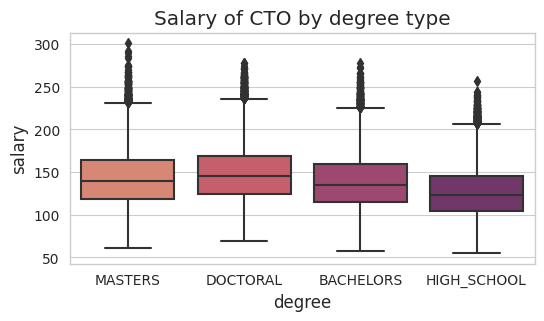

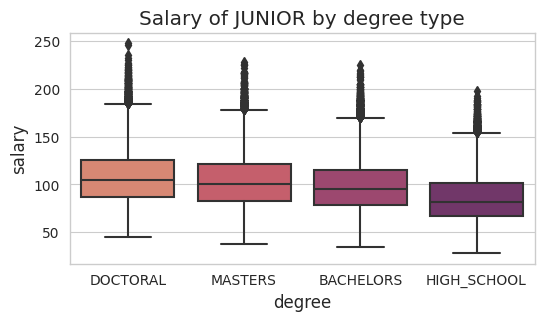

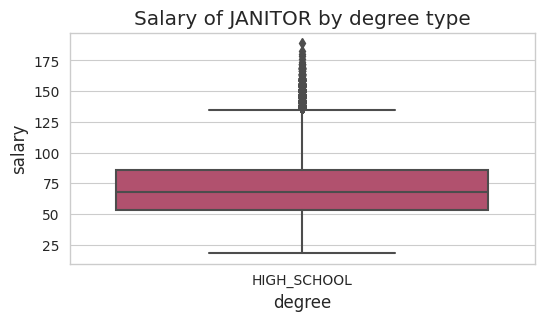

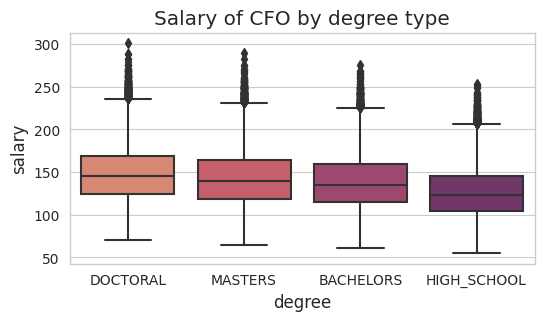

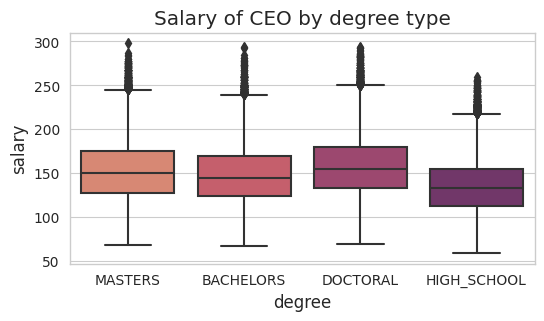

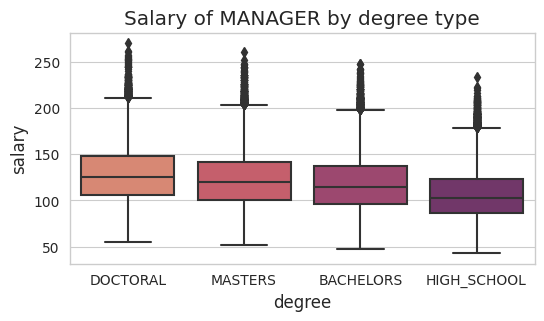

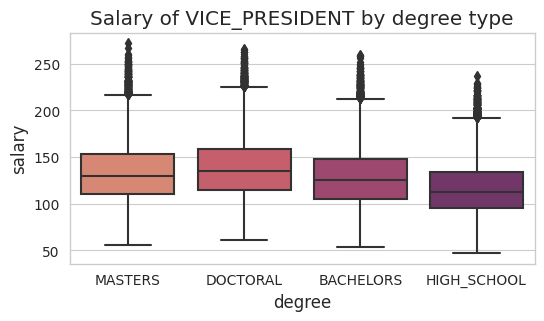

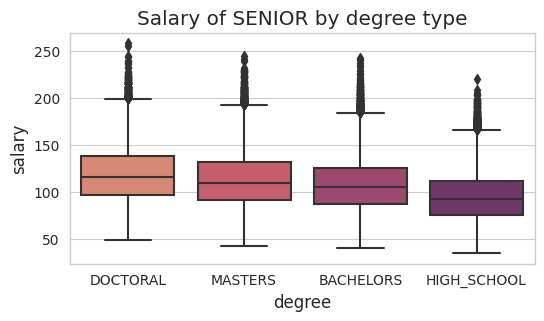

In [50]:
#Converting to Pandas DataFrame
df_pandas = df_q5.toPandas()

for job in job_list:
  df_x = df_pandas.loc[df_pandas['jobtype']==job]
  plt.figure(figsize=(6,3))
  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')
  plt.title('Salary of ' + job + ' by degree type')
  plt.show()

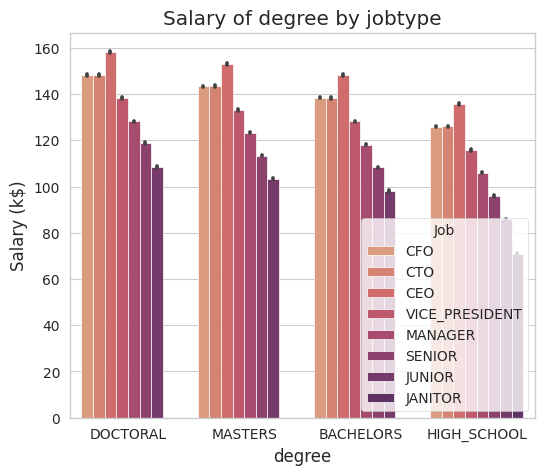

In [47]:
plt.figure(figsize=(6,5))
sns.barplot(x='degree', y = 'salary', data=df_pandas, hue='jobtype', palette='flare')
plt.legend(loc='lower right', title='Job')
plt.ylabel('Salary (k$)')
plt.title('Salary of degree by jobtype')
plt.show()

It looks like for all job types in this dataset, higher educated workers get paid more. In particular we can see a higher difference of salaries between 'high school' and 'bachelor'. Lastly is it interesting to notice that in case of JANITOR as a jobtype, there are only people with a High school education.

**Does the major affects the salary?**

In [51]:
df_q7= spark.sql('''
                  select major, salary, jobType from sal_data order by salary DESC
                 ''')

df_q7.show()

+-----------+------+-------+
|      major|salary|jobType|
+-----------+------+-------+
|ENGINEERING|   301|    CTO|
|ENGINEERING|   301|    CFO|
|ENGINEERING|   298|    CEO|
|   BUSINESS|   294|    CEO|
|ENGINEERING|   294|    CEO|
|   BUSINESS|   293|    CEO|
|    PHYSICS|   293|    CEO|
|   BUSINESS|   292|    CEO|
|   BUSINESS|   292|    CTO|
|ENGINEERING|   290|    CEO|
|ENGINEERING|   289|    CTO|
|   BUSINESS|   289|    CFO|
|   BUSINESS|   289|    CEO|
|   BUSINESS|   288|    CFO|
|   BUSINESS|   288|    CFO|
|   BUSINESS|   287|    CEO|
|   BUSINESS|   287|    CEO|
|   BUSINESS|   286|    CTO|
|    COMPSCI|   286|    CEO|
|ENGINEERING|   286|    CEO|
+-----------+------+-------+
only showing top 20 rows



NONE values have previously been observed in the major column. So dropping the column that has none values.

In [52]:
df_q7 = df_q7.replace('NONE', None)

In [53]:
df_q7 = df_q7.na.drop()

In [54]:
df_q7.groupBy('major').count().show()

+-----------+-----+
|      major|count|
+-----------+-----+
|    BIOLOGY|58379|
|ENGINEERING|58594|
|    PHYSICS|58410|
|  CHEMISTRY|58875|
|   BUSINESS|58518|
|       MATH|57800|
|    COMPSCI|58382|
| LITERATURE|58684|
+-----------+-----+



In [55]:
df_q7.groupBy('jobtype').count().show()

+--------------+-----+
|       jobtype|count|
+--------------+-----+
|           CTO|66885|
|        JUNIOR|66465|
|           CFO|66427|
|           CEO|66754|
|       MANAGER|66832|
|VICE_PRESIDENT|66771|
|        SENIOR|67508|
+--------------+-----+



In this dataframe there is no JANITOR as a jobtype: it means that people with 'janitor' as a jobtype in the dataset all have 'High school' as degree, and so no major (as stated in the previous query Q6). We need to define a new list of jobs without janitor for the following plots!

In [56]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR']

In [57]:
df_p = df_q7.toPandas()

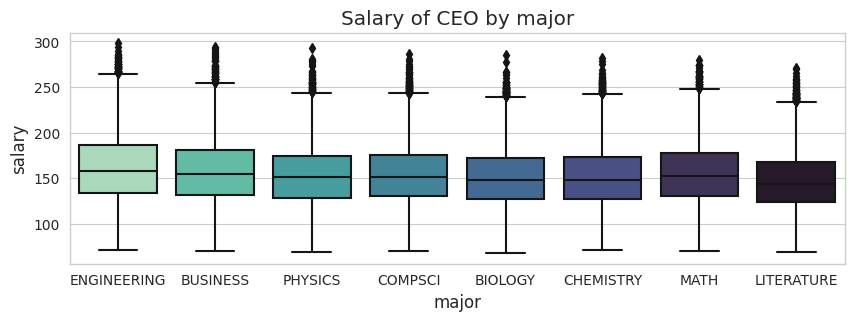

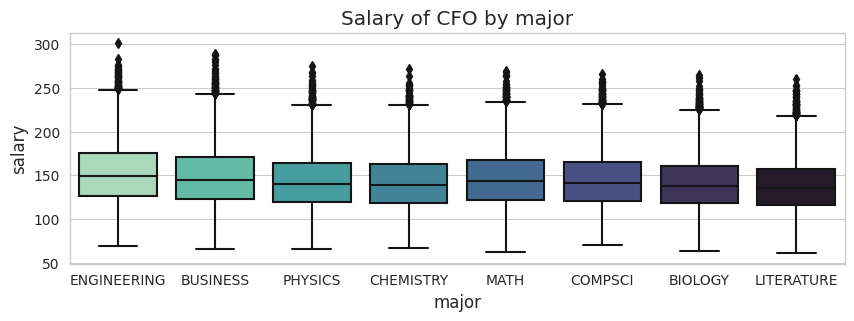

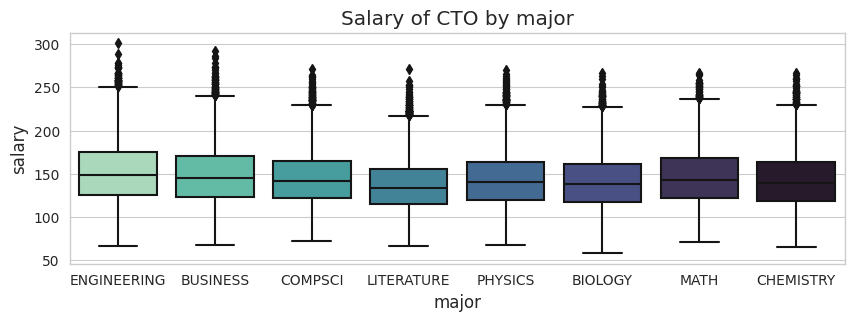

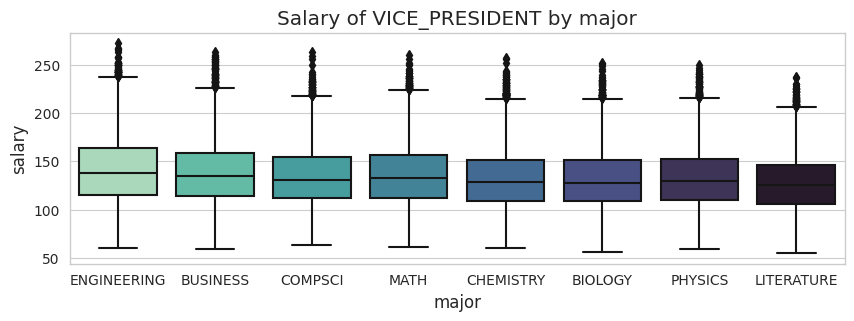

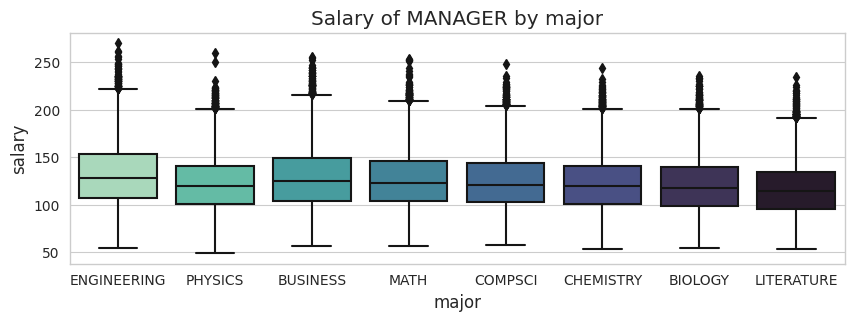

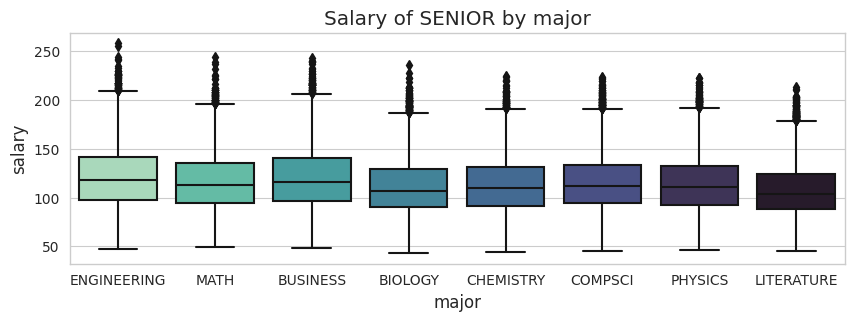

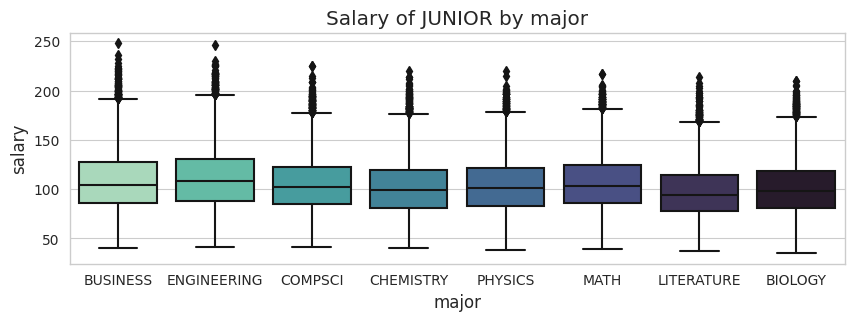

In [58]:
for job in job_list:
  df_x= df_p.loc[df_p['jobType']==job]
  plt.figure(figsize=(10,3))
  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')
  plt.title('Salary of ' + job + ' by major')
  plt.show()

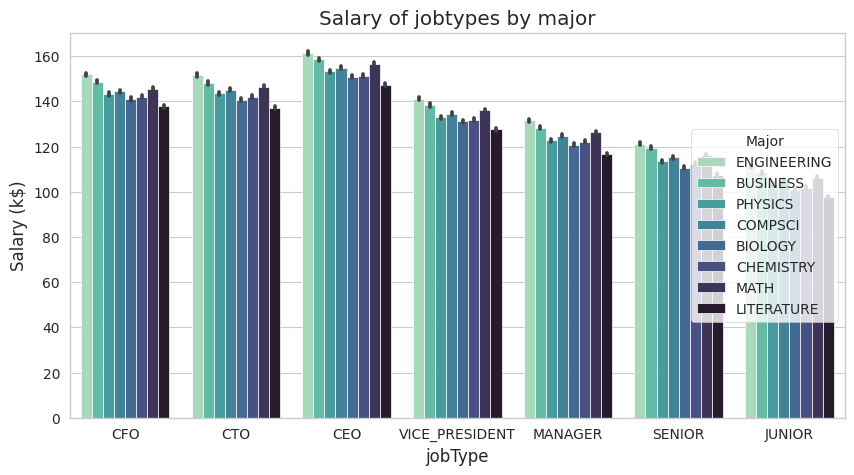

In [60]:
plt.figure(figsize=(10,5))
sns.barplot(x='jobType', y = 'salary', data=df_p, hue='major', palette='mako_r')
plt.legend(loc='center right', title='Major')
plt.ylabel('Salary (k$)')
plt.title('Salary of jobtypes by major')
plt.show()

**ML Modelling**

In [61]:
salary_data.show(1)

+----------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|           jobId|companyId|jobType| degree|major|industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|    CFO|MASTERS| MATH|  HEALTH|             10|                 83|   130|
+----------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
only showing top 1 row



First, we will create a copy of the dataframe called 'df_encoded', which will include the pre processed data.

In [62]:
df_encoded = salary_data.alias('df_encoded')
id(df_encoded) == id(salary_data)

False

We remove the 'jobid' column since it just identifies a specific worker.

In [63]:
df_encoded = df_encoded.drop('jobId')

In [64]:
cols = df_encoded.columns

cols

['companyId',
 'jobType',
 'degree',
 'major',
 'industry',
 'yearsExperience',
 'milesFromMetropolis',
 'salary']

Considering Salary as the target variable

In [70]:
#Converting salary column to pandas dataframe
salary_df = df_encoded.select('salary').toPandas()

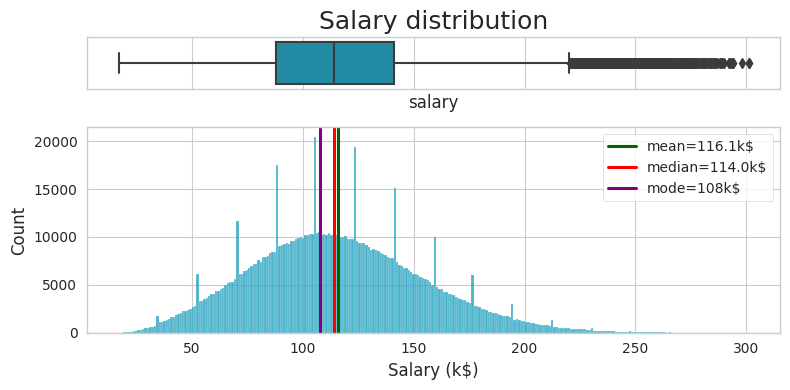

In [71]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,4),gridspec_kw={"height_ratios": (.2, .8)})
ax[0].set_title('Salary distribution',fontsize=18)
sns.boxplot(x='salary', data=salary_df, ax=ax[0], color='#0d98ba')
ax[0].set(yticks=[])
sns.histplot(x='salary', data=salary_df, ax=ax[1], color='#0d98ba')
plt.axvline(salary_df['salary'].mean(), color='darkgreen', linewidth=2.2, label='mean=' + str(np.round(salary_df['salary'].mean(),1)) + 'k$')
plt.axvline(salary_df['salary'].median(), color='red', linewidth=2.2, label='median='+ str(np.round(salary_df['salary'].median(),1)) + 'k$')
plt.axvline(salary_df['salary'].mode()[0], color='purple', linewidth=2.2, label='mode='+ str(salary_df['salary'].mode()[0]) + 'k$')
ax[1].set_xlabel('Salary (k$)')
plt.legend()
plt.tight_layout()
plt.show()

Salary feature has a right skewed long tail distribution, with some salaries which appears lots of times in the dataset (the "spikes" in this histograms).

**Label Encoding**

In [72]:
categoricalColumns = ["companyId","jobType", "degree", "major", "industry"]
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    stages += [stringIndexer]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "Index" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

Applying label encoding to degree as it is the only categorical column that has the order of degree

In [73]:
stages = []
stringIndexer = StringIndexer(inputCol = "degree", outputCol = "degreeIndex")
stages += [stringIndexer]

**One hot Encoding**

In [74]:
categoricalColumns = ["companyId","jobType", "major", "industry"]
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols + ["degreeIndex"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [75]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_encoded)
df_encoded = pipelineModel.transform(df_encoded)
selectedCols = ['features'] + cols
df_encoded = df_encoded.select(selectedCols)

In [76]:
df_encoded.show(1)

+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|            features|companyId|jobType| degree|major|industry|yearsExperience|milesFromMetropolis|salary|
+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|(86,[29,82,83,84,...|   COMP37|    CFO|MASTERS| MATH|  HEALTH|             10|                 83|   130|
+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
only showing top 1 row



We can see the presence of a "features" column, including all the different encoded features by one hot encoding and the numerical features. The column 'features' and the target column 'salary' will be passed to the ML algorithm during the training..

**Train test split**

In [78]:
train, test = df_encoded.randomSplit([0.995, 0.005], seed = 42)
print("There are %d training examples and %d test examples." % (train.count(), test.count()))

There are 994972 training examples and 5023 test examples.


**Gradient Boosting Trees**

In [80]:
gbt =  GBTRegressor(featuresCol="features", labelCol="salary", maxBins=20, maxDepth=12)



In [81]:
gbt_model = gbt.fit(train)

In [82]:
predictions = gbt_model.transform(test)

**Prediction Test**

In [83]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse

19.067709394167306

In [84]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
r2

0.7523743296473221

In [85]:
rf_results = predictions.toPandas()

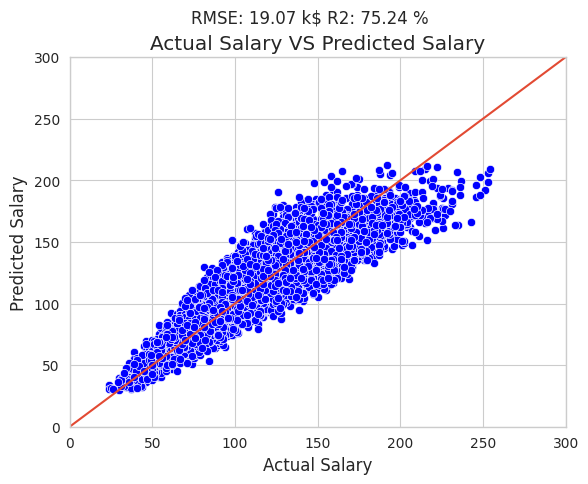

In [86]:
sns.scatterplot(x='salary', y='prediction', data=rf_results, color='blue')
plt.plot([0, 300], [0, 300])
plt.axis([0, 300, 0, 300])
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.suptitle("RMSE: {:.2f} k$ R2: {:.2f} %".format(rmse, r2*100))
plt.title('Actual Salary VS Predicted Salary')
plt.show()

In [87]:
print("RMSE: {:.2f} k$ \nR2: {:.2f} %".format(rmse, r2*100))

RMSE: 19.07 k$ 
R2: 75.24 %


In [88]:
spark.stop()